In [1]:
import pandas as pd
import random
import operator
import numpy as np
from sklearn.metrics import accuracy_score
from deap import creator, base, tools, gp, algorithms
import numpy as np
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd

# Load data
train_data = pd.read_csv('adult_training.csv')
test_data = pd.read_csv('adult_test.csv')

# Display basic information about the data and first few rows
train_info = train_data.info()
train_head = train_data.head()

train_info, train_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             5200 non-null   int64 
 1   workclass       5200 non-null   object
 2   education       5200 non-null   object
 3   marital-status  5200 non-null   object
 4   relationship    5200 non-null   object
 5   race            5200 non-null   object
 6   sex             5200 non-null   object
 7   capital-gain    5200 non-null   int64 
 8   capital-loss    5200 non-null   int64 
 9   hours-per-week  5200 non-null   int64 
 10  native-country  5200 non-null   object
 11  income          5200 non-null   object
dtypes: int64(4), object(8)
memory usage: 487.6+ KB


(None,
    age         workclass  education      marital-status   relationship   race  \
 0   28           Private  Bachelors       Never-married  Not-in-family  White   
 1   34  Self-emp-not-inc  Bachelors  Married-civ-spouse        Husband  Black   
 2   32           Private  Bachelors       Never-married  Not-in-family  Black   
 3   46           Private  Bachelors            Divorced  Not-in-family  White   
 4   44           Private  Bachelors  Married-civ-spouse        Husband  White   
 
       sex  capital-gain  capital-loss  hours-per-week native-country income  
 0    Male             0             0              40  United-States  <=50K  
 1    Male             0          1887              48  United-States   >50K  
 2  Female             0             0              40  United-States  <=50K  
 3    Male             0             0              40         Others  <=50K  
 4    Male             0             0              50  United-States   >50K  )

In [2]:
#missing values


# Replace '?' with NaN and then drop rows with missing values
train_data = train_data.replace('?', pd.NA).dropna()

# Display basic information about the data after handling missing values
train_info_after_missing_values = train_data.info()
train_info_after_missing_values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             5200 non-null   int64 
 1   workclass       5200 non-null   object
 2   education       5200 non-null   object
 3   marital-status  5200 non-null   object
 4   relationship    5200 non-null   object
 5   race            5200 non-null   object
 6   sex             5200 non-null   object
 7   capital-gain    5200 non-null   int64 
 8   capital-loss    5200 non-null   int64 
 9   hours-per-week  5200 non-null   int64 
 10  native-country  5200 non-null   object
 11  income          5200 non-null   object
dtypes: int64(4), object(8)
memory usage: 487.6+ KB


In [3]:
#encoding the target variable income

from sklearn.preprocessing import LabelEncoder

# Convert target variable 'income' to numerical format
label_encoder = LabelEncoder()
train_data['income'] = label_encoder.fit_transform(train_data['income'])

# One-hot encode categorical features
train_data = pd.get_dummies(train_data, drop_first=True)

# Display first few rows of the data after preprocessing
train_head_after_preprocessing = train_data.head()
train_head_after_preprocessing


,age,capital-gain,capital-loss,hours-per-week,income,workclass_Private,workclass_Self-emp-not-inc,workclass_State-gov,education_Doctorate,education_HS-grad,...,education_Some-college,marital-status_Married-civ-spouse,marital-status_Never-married,relationship_Not-in-family,relationship_Other-relative,relationship_Wife,race_Black,race_White,sex_Male,native-country_United-States
0,28,0,0,40,0,1,0,0,0,0,...,0,0,1,1,0,0,0,1,1,1
1,34,0,1887,48,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,1,1
2,32,0,0,40,0,1,0,0,0,0,...,0,0,1,1,0,0,1,0,0,1
3,46,0,0,40,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
4,44,0,0,50,1,1,0,0,0,0,...,0,1,0,0,0,0,0,1,1,1


In [4]:
#gp parameters

# Set the GP parameters
POPULATION_SIZE = 200
P_CROSSOVER = 0.8
P_MUTATION = 0.2
MAX_GENERATIONS = 40
HALL_OF_FAME_SIZE = 5

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

MIN_TREE_HEIGHT = 2
MAX_TREE_HEIGHT = 6
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2


In [5]:
# Define custom functions for handling categorical data
def is_equal(arg1, arg2):
    return 1 if arg1 == arg2 else 0

def is_not_equal(arg1, arg2):
    return 1 if arg1 != arg2 else 0

def safe_add(x, y):
    try:
        return x + y
    except TypeError:
        return 0

def safe_sub(x, y):
    try:
        return x - y
    except TypeError:
        return 0

def safe_mul(x, y):
    try:
        return x * y
    except TypeError:
        return 0

def safe_div(x, y):
    try:
        return x / y
    except (TypeError, ZeroDivisionError):
        return 1


In [6]:
from deap import creator, base, tools, gp
import numpy as np
import random

# Separate features and target variable
train_features = train_data.drop('income', axis=1)
train_target = train_data['income']



from deap import creator

# Define the creator
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

In [7]:
# Create a gp.PrimitiveSet
# Update the pset to match the new structure of the data
pset = gp.PrimitiveSetTyped("MAIN", [float] * train_features.shape[1], int)

# Add functions to the primitive set
pset.addPrimitive(safe_add, [float, float], float)
pset.addPrimitive(safe_sub, [float, float], float)
pset.addPrimitive(safe_mul, [float, float], float)
pset.addPrimitive(safe_div, [float, float], float)
pset.addPrimitive(is_equal, [float, float], int)
pset.addPrimitive(is_not_equal, [float, float], int)

# Add some constants
pset.addEphemeralConstant("rand101", lambda: random.randint(-1, 1), int)




# Add terminals to the primitive set
#for col in train_data.columns:
#    if train_data[col].dtype == 'int64':
#        pset.addTerminal(col, int)
#    else:
#        pset.addTerminal(col, object)

# Add some constants
#pset.addTerminal(1, int)
#pset.addTerminal(0, int)

In [8]:


# Define the fitness function
def fitness_function(individual, data, target):
    func = gp.compile(expr=individual, pset=pset)
    predictions = np.round([func(*row) for row in data.values])  # Use .values to get a numpy representation
    accuracy = accuracy_score(target, predictions)
    return (accuracy,)  # Return a tuple with a single accuracy value

# Create the toolbox
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", fitness_function, data=train_features, target=train_target)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# Run genetic programming
pop = toolbox.population(n=POPULATION_SIZE)
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, P_CROSSOVER, P_MUTATION, MAX_GENERATIONS, stats, halloffame=hof)

# Display the best individual and its fitness value
best_individual = hof[0]
best_fitness = best_individual.fitness.values[0]

best_individual, best_fitness


gen	nevals	avg     	min     	max     
0  	200   	0.495264	0.326154	0.740385
1  	154   	0.608771	0.309808	0.693269
2  	180   	0.64046 	0       	0.739615
3  	159   	0.648288	0.315385	0.739615
4  	166   	0.639627	0.3125  	0.726346
5  	166   	0.650142	0       	0.737692
6  	172   	0.640801	0.307885	0.737692
7  	172   	0.652195	0       	0.737692
8  	151   	0.652571	0       	0.733654
9  	155   	0.652768	0       	0.729423
10 	144   	0.666038	0.339423	0.735192
11 	158   	0.65837 	0       	0.736154
12 	171   	0.65528 	0.335385	0.742115
13 	170   	0.655783	0       	0.741923
14 	170   	0.644747	0       	0.741923
15 	165   	0.661784	0.317885	0.759615
16 	179   	0.65421 	0       	0.759423
17 	171   	0.662646	0.3125  	0.759423
18 	169   	0.673945	0       	0.759423
19 	163   	0.695555	0.3925  	0.759615
20 	163   	0.692398	0.335385	0.759615
21 	173   	0.697312	0.335385	0.759615
22 	170   	0.692793	0.335385	0.759423
23 	169   	0.70079 	0.335385	0.759615
24 	158   	0.711705	0.353846	0.760577
25 	167   	0

([<deap.gp.Primitive at 0x7fed4ad48ef0>,
 0.7607692307692308)

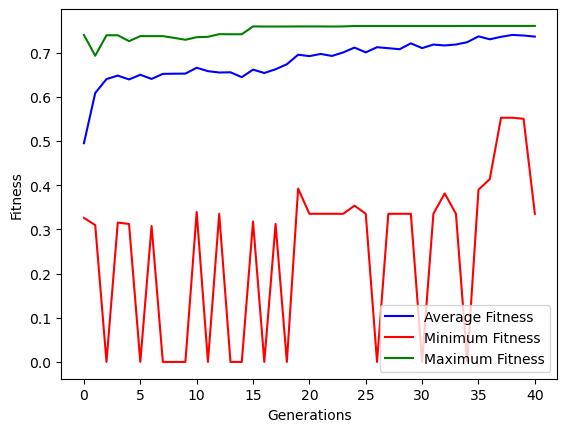

In [9]:
import matplotlib.pyplot as plt

# Extract values from the logbook
gen = log.select("gen")
avg_fit = log.select("avg")
min_fit = log.select("min")
max_fit = log.select("max")

# Plot the data
fig, ax1 = plt.subplots()

line1 = ax1.plot(gen, avg_fit, "b-", label="Average Fitness")
line2 = ax1.plot(gen, min_fit, "r-", label="Minimum Fitness")
line3 = ax1.plot(gen, max_fit, "g-", label="Maximum Fitness")

ax1.set_xlabel("Generations")
ax1.set_ylabel("Fitness")

lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="best")

plt.show()


In [15]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

def predict_gp_individual(individual, data, pset):
    func = gp.compile(expr=individual, pset=pset)
    predictions = np.round([func(*row) for row in data.values])  # Use .values to get a numpy representation
    return predictions

# Load the test data and preprocess it in the same way as the training data
#test_data = pd.read_csv('path/to/test/data.csv')
# Load the test data and preprocess it in the same way as the training data
# test_data = pd.read_csv('path/to/test/data.csv')
# Load the test data and preprocess it in the same way as the training data
# Load the test data and preprocess it in the same way as the training data
# test_data = pd.read_csv('path/to/test/data.csv')
test_data = test_data.replace('?', pd.NA).dropna()
test_data = pd.get_dummies(test_data, drop_first=True)

# Predict the test set using the best GP individual
test_predictions = predict_gp_individual(best_individual, test_data, pset)

# Save the predictions to a CSV file
predictions_df = pd.DataFrame({'ID': range(1, len(test_predictions) + 1), 'income': test_predictions})
predictions_df.to_csv('test_predictions1.csv', index=False)

# Check the number of rows in the test predictions CSV file
num_rows = len(predictions_df)
print(f"Number of rows in the test predictions CSV file: {num_rows}")


Number of rows in the test predictions CSV file: 10402


In [11]:
test_data.columns

Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week',
       'workclass_Private', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'education_Doctorate', 'education_HS-grad',
       'education_Masters', 'education_Some-college',
       'marital-status_Married-civ-spouse', 'marital-status_Never-married',
       'relationship_Not-in-family', 'relationship_Other-relative',
       'relationship_Wife', 'race_Black', 'race_White', 'sex_Male',
       'native-country_United-States'],
      dtype='object')

In [12]:
predictions_df


,ID,income
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
10397,10398,0
10398,10399,1
10399,10400,0
10400,10401,0


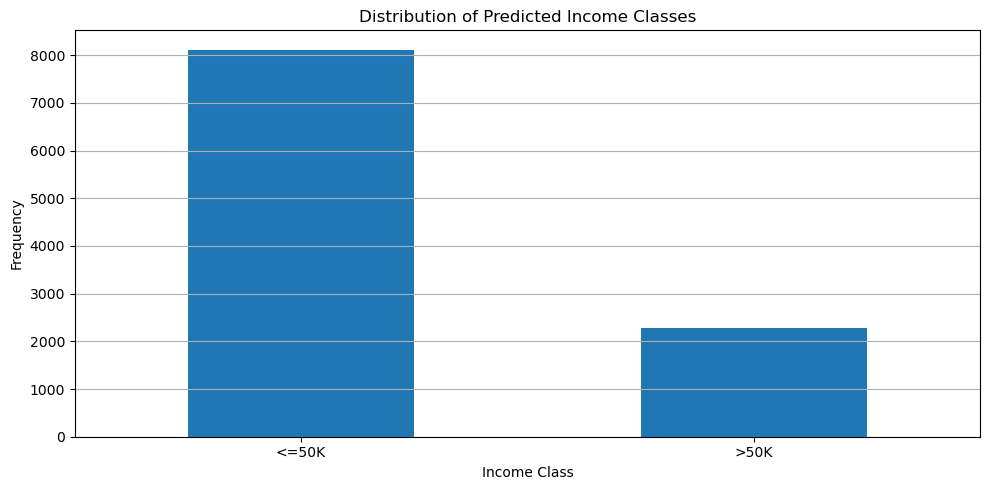

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the predictions CSV file
predictions_df = pd.read_csv('test_predictions.csv')

# Create a histogram for predicted values
fig, ax = plt.subplots(figsize=(10, 5))

predictions_df['income'].value_counts().plot(kind='bar')

plt.xlabel('Income Class')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Income Classes')
plt.xticks(ticks=[0, 1], labels=['<=50K', '>50K'], rotation=0)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


In [14]:
predictions_df.columns

Index(['ID', 'income'], dtype='object')